# **Third Objective: Financial Development Systems**


---



---







Target Variable: FDI


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import shap

In [10]:
pivot_path = "/content/pivoted_transformed_data.csv"
financial_df = pd.read_csv(pivot_path)

financial_df['Bank nonperforming loans to total gross loans (%)'] = financial_df['Bank nonperforming loans to total gross loans (%)'].max() - financial_df['Bank nonperforming loans to total gross loans (%)']
financial_indicators = [
    'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
    'Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of population ages 15+)',
    'Domestic credit to private sector (% of GDP)',
    'Domestic credit to private sector by banks (% of GDP)',
    'Bank nonperforming loans to total gross loans (%)',
    'Bank capital to assets ratio (%)',
    'Broad money (% of GDP)',
    'Broad money growth (annual %)',
    'Commercial bank branches (per 100,000 adults)',
    'Automated teller machines (ATMs) (per 100,000 adults)',
    'Borrowers from commercial banks (per 1,000 adults)',
    'Depositors with commercial banks (per 1,000 adults)',
    'Market capitalization of listed domestic companies (% of GDP)',
    'Stocks traded, total value (% of GDP)',
    'Stocks traded, turnover ratio of domestic shares (%)'
]

# Min-Max scaling
scaler = MinMaxScaler()
financial_df_normalized = pd.DataFrame(
    scaler.fit_transform(financial_df[financial_indicators]),
    columns=financial_indicators,
    index=financial_df.index
)

# Group indicators by dimension
depth_indicators = [
    'Domestic credit to private sector (% of GDP)',
    'Domestic credit to private sector by banks (% of GDP)',
    'Broad money (% of GDP)',
    'Market capitalization of listed domestic companies (% of GDP)'
]

access_indicators = [
    'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
    'Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of population ages 15+)',
    'Commercial bank branches (per 100,000 adults)',
    'Automated teller machines (ATMs) (per 100,000 adults)',
    'Borrowers from commercial banks (per 1,000 adults)',
    'Depositors with commercial banks (per 1,000 adults)'
]

efficiency_indicators = [
    'Stocks traded, total value (% of GDP)',
    'Stocks traded, turnover ratio of domestic shares (%)',
    'Broad money growth (annual %)'
]

stability_indicators = [
    'Bank nonperforming loans to total gross loans (%)',
    'Bank capital to assets ratio (%)'
]

financial_df['Depth_Index'] = financial_df_normalized[depth_indicators].mean(axis=1)
financial_df['Access_Index'] = financial_df_normalized[access_indicators].mean(axis=1)
financial_df['Efficiency_Index'] = financial_df_normalized[efficiency_indicators].mean(axis=1)
financial_df['Stability_Index'] = financial_df_normalized[stability_indicators].mean(axis=1)

# Calculate overall FDI (equal weights for each dimension)
financial_df['FDI'] = financial_df[['Depth_Index', 'Access_Index', 'Efficiency_Index', 'Stability_Index']].mean(axis=1)

# Scale FDI to 0-100 range
financial_df['FDI'] = financial_df['FDI'] * 100
print(financial_df[['Country Name', 'Year', 'FDI']].sort_values(['Country Name', 'Year']))

     Country Name  Year        FDI
0         Albania  2021        NaN
1         Albania  2021  51.058490
2         Albania  2021        NaN
3         Albania  2021        NaN
4         Albania  2021        NaN
...           ...   ...        ...
1363      Uruguay  2023  53.730772
1364      Uruguay  2023        NaN
1365      Uruguay  2023        NaN
1366      Uruguay  2023        NaN
1367      Uruguay  2023        NaN

[1368 rows x 3 columns]


In [11]:
financial_df['Quarter'] = financial_df['Quarter'].astype(str)
financial_annual_only = financial_df[financial_df['Quarter'] == '0']
financial_df
columns_to_keep = ['Country Name', 'Year'] + financial_indicators + ['FDI']
financial_annual_data = financial_annual_only[columns_to_keep]

financial_annual_data.to_csv('/content/financial_annual_data.csv', index=False)

columns_for_aggregation = financial_indicators + ['FDI']
financial_annual_aggregated = financial_annual_only.groupby(['Country Name', 'Year'], as_index=False)[columns_for_aggregation].first()

financial_annual_aggregated.to_csv('/content/financial_annual_data_cleaned.csv', index=False)

print("FDI calculation complete.")
print("Sample of Deduplicated Annual financial Equity Data:")
print(financial_annual_aggregated.head())

FDI calculation complete.
Sample of Deduplicated Annual financial Equity Data:
  Country Name  Year  \
0      Albania  2021   
1      Albania  2022   
2      Albania  2023   
3    Argentina  2021   
4    Argentina  2022   

   Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)  \
0                                           3.737219                                                                 
1                                           3.737219                                                                 
2                                           4.267436                                                                 
3                                           4.206959                                                                 
4                                           4.239749                                                                 

   Account ownership at a financial institution or with a mobile-mo

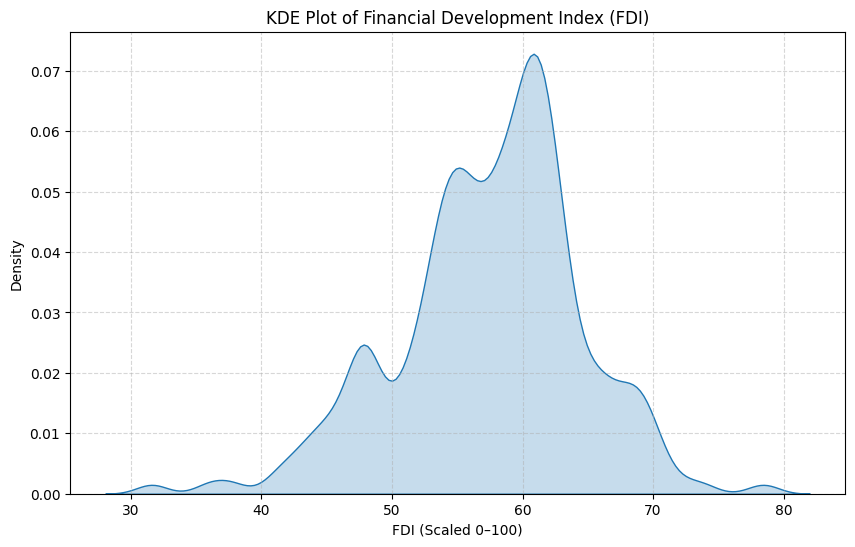

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
financial_annual_aggregated = pd.read_csv('/content/financial_annual_data_cleaned.csv')
plt.figure(figsize=(10, 6))
sns.kdeplot(data=financial_annual_aggregated, x='FDI', fill=True, bw_adjust=0.5)
plt.title('KDE Plot of Financial Development Index (FDI)')
plt.xlabel('FDI (Scaled 0–100)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [13]:
X = financial_annual_aggregated[financial_indicators]
y = financial_annual_aggregated['FDI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R² Score: {rf_r2:.3f}")

Random Forest RMSE: 3.22
Random Forest R² Score: 0.819


In [15]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost R² Score: {xgb_r2:.3f}")

XGBoost RMSE: 2.80
XGBoost R² Score: 0.863


In [16]:
xgb_l2 = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    reg_lambda=1,
    random_state=42
)
xgb_l2.fit(X_train, y_train)
y_pred_l2 = xgb_l2.predict(X_test)

print(f"L2 Regularized XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_l2)):.2f}")
print(f"L2 Regularized XGBoost R²: {r2_score(y_test, y_pred_l2):.3f}")

L2 Regularized XGBoost RMSE: 2.80
L2 Regularized XGBoost R²: 0.863


In [17]:
param_grid = {
    'reg_lambda': [0, 0.1, 1, 5, 10],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\nBest Parameters Found:", grid_search.best_params_)
print(f"Best XGBoost RMSE on Test Set: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.2f}")
print(f"Best XGBoost R² on Test Set: {r2_score(y_test, y_pred_best):.3f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 0.1}
Best XGBoost RMSE on Test Set: 2.33
Best XGBoost R² on Test Set: 0.905


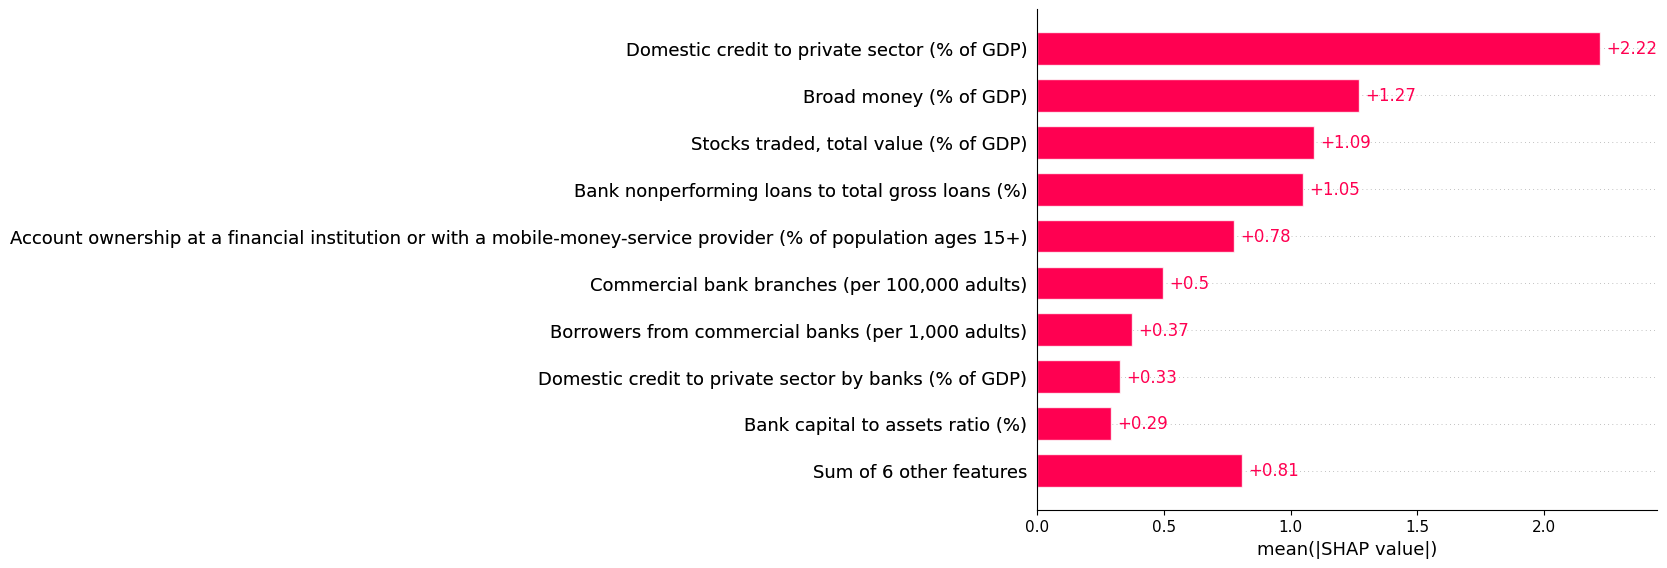

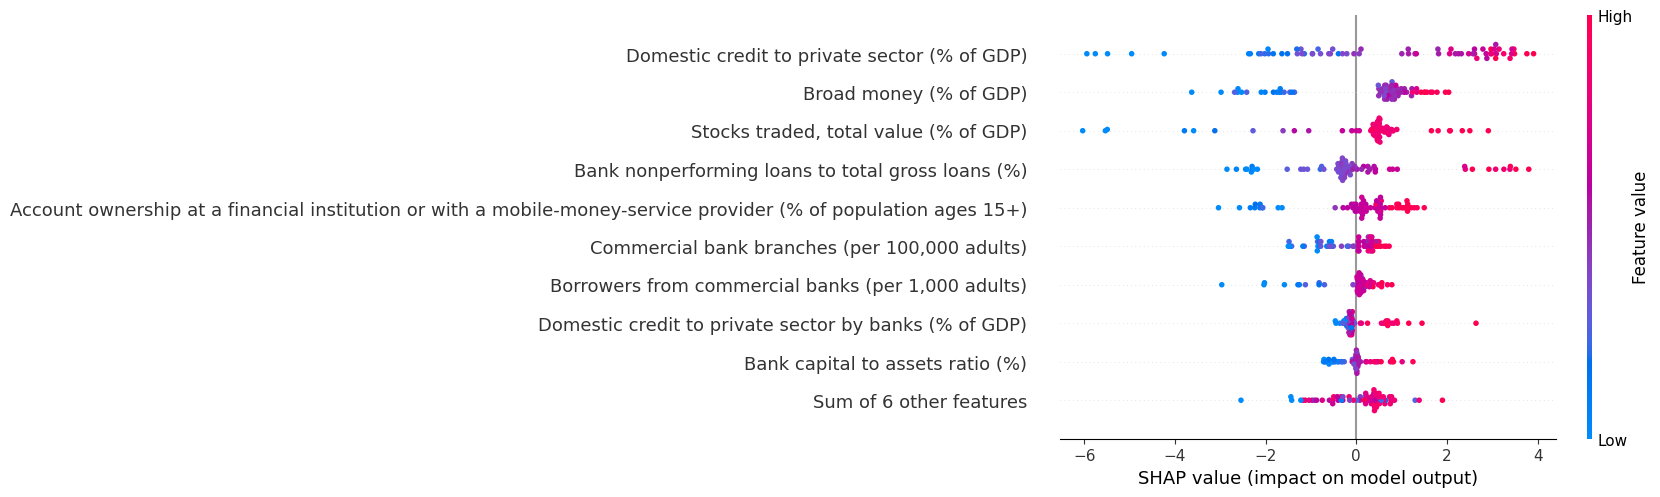

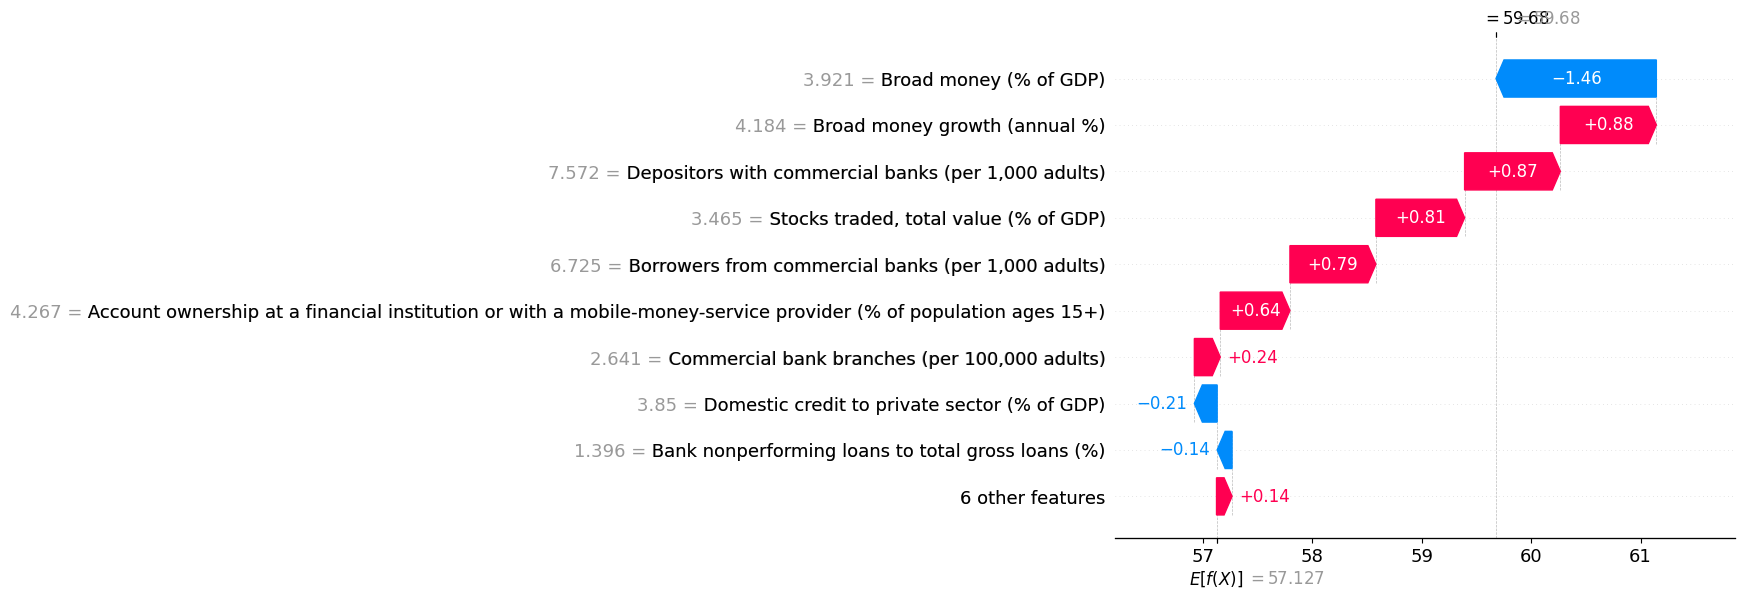

In [20]:
explainer = shap.Explainer(best_model)

shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=10)
shap.plots.beeswarm(shap_values, max_display=10)

idx = 0
shap.plots.waterfall(shap_values[idx])
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df['Prediction'] = best_model.predict(X_test)
shap_df.to_csv('/content/FDI_SHAP_values.csv', index=False)

<ipython-input-19-bcdd06ea9b05>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=performance_df, palette='viridis', ax=ax1)
<ipython-input-19-bcdd06ea9b05>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R²', data=performance_df, palette='viridis', ax=ax2)


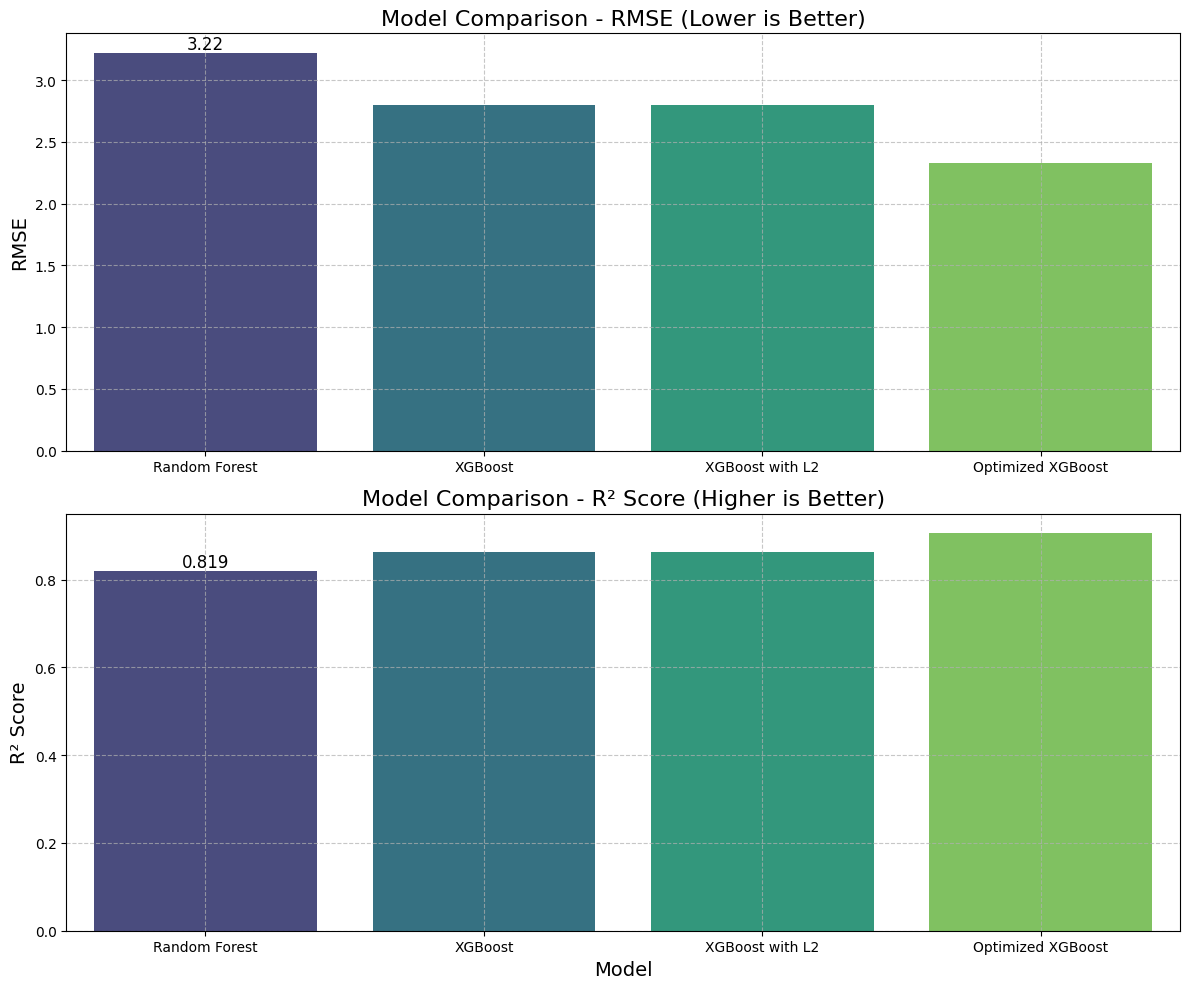

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe with model performance results
models = ['Random Forest', 'XGBoost', 'XGBoost with L2', 'Optimized XGBoost']
rmse_values = [rf_rmse, xgb_rmse, np.sqrt(mean_squared_error(y_test, y_pred_l2)), np.sqrt(mean_squared_error(y_test, y_pred_best))]
r2_values = [rf_r2, xgb_r2, r2_score(y_test, y_pred_l2), r2_score(y_test, y_pred_best)]

# Create DataFrame for plotting
performance_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values,
    'R²': r2_values
})

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot RMSE values (lower is better)
sns.barplot(x='Model', y='RMSE', data=performance_df, palette='viridis', ax=ax1)
ax1.set_title('Model Comparison - RMSE (Lower is Better)', fontsize=16)
ax1.set_ylabel('RMSE', fontsize=14)
ax1.set_xlabel('')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.bar_label(ax1.containers[0], fmt='%.2f', fontsize=12)

# Plot R² values (higher is better)
sns.barplot(x='Model', y='R²', data=performance_df, palette='viridis', ax=ax2)
ax2.set_title('Model Comparison - R² Score (Higher is Better)', fontsize=16)
ax2.set_ylabel('R² Score', fontsize=14)
ax2.set_xlabel('Model', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.bar_label(ax2.containers[0], fmt='%.3f', fontsize=12)

plt.tight_layout()
plt.show()